## ALGYAN Community 2022.09.26. 月曜日
### エッジAI入門＆活用シリーズ#2 『ONNXモデル』 編
### ONNXモデルと既存ディープラーニングモデルとの性能比較 : PyTorch vs ONNX - 全美貞(Mijeong Jeon)

### コンテンツ一覧
1. ResNet50 モデルを読み込む
2. Pytorch モデルを ONNX モデルに変換する
3. 画像データの準備
4. pytorch と onnx のパフォーマンス比較 1. 結果
5. pytorch と onnx のパフォーマンス比較 2. 速度

### Dependency 
* Python 3.8
* PyTorch 1.12.1
* onnx 1.12.0
* onnxruntime 1.12.1


In [1]:
# 1. ResNet50 モデルを読み込む

import torch
import torchvision.models as models

# import
torch_model = models.resnet50(pretrained=True)

/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [2]:
# 2. Pytorch モデルを ONNX モデルに変換する

# ランダムtorch入力値の生成
input = torch.rand(1,3,224,224)

# Pytorch モデルを ONNX モデルに変換する
torch.onnx.export(torch_model, input, 'onnx_resnet.onnx')

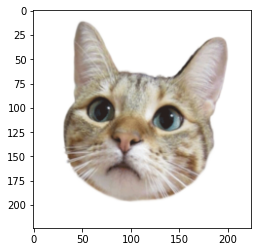

In [3]:
# 3. 画像データの準備

from PIL import Image
import numpy as np
from numpy import moveaxis
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

img = Image.open("cat.jpg")

resize = transforms.Resize([224, 224])
img = resize(img)

img_arr = np.array(img).astype(np.float32)
data = moveaxis(img_arr, 2, 0).reshape(1,3,224,224)

plt.imshow(img)

In [8]:
# 4. Pyztorch モデルと ONNX モデル : 精度の予測

import onnxruntime

# PyTorch Predict
torch_data = torch.from_numpy(data)

with torch.no_grad():
    torch_model.eval()  
    output =torch_model(torch_data)
    index = output.data.cpu().numpy().argmax()
    print("PyTorch result: ", index)

# ONNX Predict
onnx_model = onnxruntime.InferenceSession('onnx_resnet.onnx', providers=['CPUExecutionProvider'])
result = onnx_model.run(None,{onnx_model.get_inputs()[0].name: data})

prob = result[0]
onnx_pred = prob.ravel()
print("ONNX result: ", np.argmax(onnx_pred))

PyTorch result:  818
ONNX result:  818


In [7]:
# 5. PyTorch モデルと ONNX モデル: 推論速度

import time

torch_data = torch.from_numpy(data)

# PyTorch Time
start_time = time.time()
torch_model(torch_data)
torch_time = time.time() - start_time
print("PyTorch running time: ", torch_time)

# ONNX Time
start_time = time.time()
onnx_model.run(None,{onnx_model.get_inputs()[0].name: data})
onnx_time = time.time() - start_time
print("ONNX running time: ", onnx_time)

PyTorch running time:  0.07818865776062012
ONNX running time:  0.03294849395751953


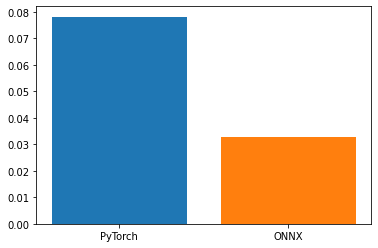

In [9]:
plt.figure()

frameworks = ["PyTorch", "ONNX"]
times = [torch_time, onnx_time]

plt.bar(frameworks[0], times[0])
plt.bar(frameworks[1], times[1])
plt.show()
